In [40]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split

# Data Preprocessing

In [33]:
data_path = '../data/'
df = pd.read_csv(data_path + 'spam.csv', encoding='latin-1')
df.head(3)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN


In [34]:
# remove unnecessary columns
del df['Unnamed: 2']
del df['Unnamed: 3']
del df['Unnamed: 4']
# ham: 0, spam: 1
df["v1"] = df["v1"].replace(to_replace=['ham', 'spam'], value=[0, 1]) 

df.head(3)

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...


In [35]:
print(df.isnull().values.any()) # False : no null values
print(len(df['v2']) != df['v2'].nunique()) # True : there are duplicates

# drop duplicate
df.drop_duplicates(subset=['v2'], inplace=True)
print(len(df['v2']) != df['v2'].nunique()) # False : no duplicates

False
True
False


5169
4516
653
6.915773353751915


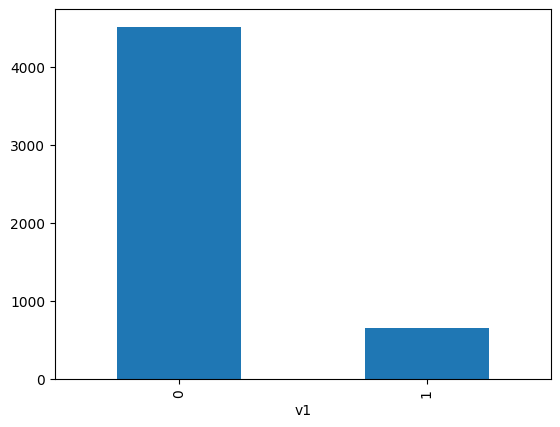

In [43]:
df['v1'].value_counts().plot(kind='bar')
print(len(df['v1']))
print(df['v1'].value_counts()[0])
print(df['v1'].value_counts()[1])
print(df['v1'].value_counts()[0] / df['v1'].value_counts()[1])

In [42]:
X_train = df['v2']
y_train = df['v1']
# random_state: seed, stratify: same ratio of y_train
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=777, stratify=y_train) 

print(y_train.value_counts()[0] / y_train.value_counts()[1])
print(y_test.value_counts()[0] / y_test.value_counts()[1])

6.921455938697318
6.893129770992366


# Tokenizing

In [66]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train) # mapping word to index on frequency order
X_train_encoded = tokenizer.texts_to_sequences(X_train) # convert X_train data to index
X_test_encoded = tokenizer.texts_to_sequences(X_test)

print(tokenizer.word_index['the'])
print(X_train_encoded[:5])

5
[[57, 553, 17, 40, 3482, 2361, 70, 11, 441, 1310, 1, 120, 40, 3483, 3, 153, 7, 647, 11, 2362, 1, 89, 15, 3, 7, 72, 4, 1311, 389, 44, 941, 5, 746, 3484, 3485, 15, 3486, 3487, 3, 3488, 2363], [166, 119, 22, 161, 245, 792], [10, 109, 368, 1, 942, 2, 648, 3, 113, 1, 1513, 3, 34, 98, 57, 195, 15, 10], [150, 38, 1312, 246, 12, 131, 522, 29, 793, 342, 46, 943], [39, 23, 38, 697, 4, 2364, 1830, 584, 2, 207, 127, 3489, 17, 128, 82, 22, 27, 1, 18, 8]]


In [67]:
# analyze tokenized data
total_word = len(tokenizer.word_index)
total_freq = 0
threshold = 2 # choose words that appear more than 2 times

rare_word = 0
rare_word_freq = 0

for k, f in tokenizer.word_counts.items():
    total_freq += f
    
    if f < threshold:
        rare_word += 1
        rare_word_freq += f
        
print('total word:', total_word)
print('total freq:', total_freq)
print('rare word:', rare_word)
print('rare word freq:', rare_word_freq)
print('rare word ratio:', rare_word / total_word)
print('rare word freq ratio:', rare_word_freq / total_freq)

total word: 7842
total freq: 64325
rare word: 4361
rare word freq: 4361
rare word ratio: 0.5561081356796735
rare word freq ratio: 0.0677963466770307


vocab size: 7843
max X_train len: 162
max X_test len: 183
max X len: 183
avg X_train len: 15.556227327690447


(array([ 92., 696., 809., 522., 471., 282., 218., 260., 386., 180., 100.,
         29.,  25.,   9.,   8.,   8.,   9.,   5.,   2.,   4.,   1.,   5.,
          1.,   3.,   0.,   2.,   0.,   3.,   0.,   0.,   2.,   0.,   0.,
          0.,   0.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([  0.  ,   3.24,   6.48,   9.72,  12.96,  16.2 ,  19.44,  22.68,
         25.92,  29.16,  32.4 ,  35.64,  38.88,  42.12,  45.36,  48.6 ,
         51.84,  55.08,  58.32,  61.56,  64.8 ,  68.04,  71.28,  74.52,
         77.76,  81.  ,  84.24,  87.48,  90.72,  93.96,  97.2 , 100.44,
        103.68, 106.92, 110.16, 113.4 , 116.64, 119.88, 123.12, 126.36,
        129.6 , 132.84, 136.08, 139.32, 142.56, 145.8 , 149.04, 152.28,
        155.52, 158.76, 162.  ]),
 <BarContainer object of 50 artists>)

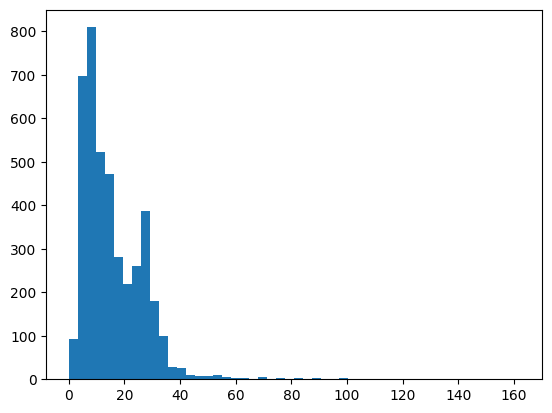

In [69]:
vocab_size = len(tokenizer.word_index) + 1 # +1 for padding

max_X_train_len = max(len(d) for d in X_train_encoded)
max_X_test_len = max(len(d) for d in X_test_encoded)
max_X_len = max(max_X_train_len, max_X_test_len)
avg_X_train_len = sum(map(len, X_train_encoded)) / len(X_train_encoded)

print('vocab size:', vocab_size)
print('max X_train len:', max_X_train_len)
print('max X_test len:', max_X_test_len)
print('max X len:', max_X_len)
print('avg X_train len:', avg_X_train_len)

plt.hist([len(d) for d in X_train_encoded], bins=50)

In [70]:
# padding 
X_train_encoded_padded = pad_sequences(X_train_encoded, maxlen=max_X_len)
X_test_encoded_padded = pad_sequences(X_test_encoded, maxlen=max_X_len)
print(X_train_encoded_padded.shape)
print(X_test_encoded_padded.shape)

(4135, 183)
(1034, 183)


# Modeling

In [71]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, Flatten, SimpleRNN

In [74]:
embedding_dims = 32
rnn_hidden_dims = 32

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dims))
model.add(SimpleRNN(rnn_hidden_dims))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 32)          250976    
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 253089 (988.63 KB)
Trainable params: 253089 (988.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [77]:
hist = model.fit(X_train_encoded_padded, y_train, epochs=4, batch_size=64, validation_split=0.2)

Epoch 1/4
52/52 [==============================] - 1s 15ms/step - loss: 0.0213 - accuracy: 0.9967 - val_loss: 0.0812 - val_accuracy: 0.9782
Epoch 2/4
52/52 [==============================] - 1s 15ms/step - loss: 0.0167 - accuracy: 0.9973 - val_loss: 0.0772 - val_accuracy: 0.9807
Epoch 3/4
52/52 [==============================] - 1s 15ms/step - loss: 0.0098 - accuracy: 0.9991 - val_loss: 0.0766 - val_accuracy: 0.9807
Epoch 4/4
52/52 [==============================] - 1s 15ms/step - loss: 0.0106 - accuracy: 0.9979 - val_loss: 0.0840 - val_accuracy: 0.9807


In [76]:
model.evaluate(X_test_encoded_padded, y_test)

33/33 [==============================] - 0s 3ms/step - loss: 0.0865 - accuracy: 0.9739


[0.08653198927640915, 0.9738878011703491]

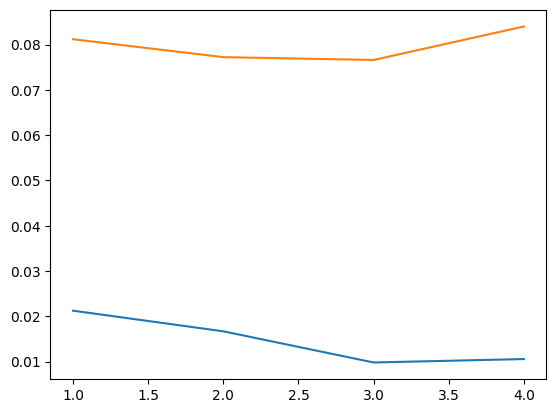

In [81]:
epochs = range(1, len(hist.history['accuracy']) + 1)
plt.plot(epochs, hist.history['loss'], label='Training loss')
plt.plot(epochs, hist.history['val_loss'], label='Validation loss')
plt.show()